In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as mt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModel
import cv2
import warnings
from torch.utils.data import Dataset,DataLoader,random_split
from IPython.display import clear_output
import matplotlib.pyplot as plt 
warnings.filterwarnings("ignore")


In [45]:
!pip install mediapy

In [4]:
data_frame=pd.read_csv('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv')[:2000]
train_size=int(0.6*len(data_frame))
val_size=int(0.2*len(data_frame))
test_size=int(len(data_frame)-train_size-val_size)


In [5]:
train,val,test=random_split(data_frame,[train_size,test_size,val_size])
train_data=data_frame.iloc[train.indices]
val_data=data_frame.iloc[val.indices]
test_data=data_frame.iloc[test.indices]

In [6]:
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE

In [7]:
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small')


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:

class depthData(Dataset):
    def __init__(self,img_pd,preprocess=None):
        self.img_pd=img_pd
        
        self.preprocess=preprocess

    def __getitem__(self, idx):
        # Access a row in the DataFrame
        sample_i = self.img_pd.iloc[idx]
        
        # Get file names
        img_path = os.path.join('/kaggle/input/nyu-depth-v2/nyu_data', sample_i[0])
        depth_path = os.path.join('/kaggle/input/nyu-depth-v2/nyu_data', sample_i[1])

        # Load the images
        # img = torch.tensor(np.array(Image.open(img_path).convert("RGB").resize((504,378))),dtype=float ) # Convert to RGB
        img =Image.open(img_path) # Convert to RGB
        # depth = torch.tensor(np.array(Image.open(depth_path).resize((244,244))),dtype=float ) # 16-bit depth image
        depth = torch.tensor(np.array(Image.open(depth_path).resize((256,256))),dtype=float ) # 16-bit depth image

        # Optional preprocessing
        if self.preprocess:
            img = self.preprocess(img)['pixel_values'][0]
            depth=(depth-depth.min())/(depth.max()-depth.min())

        return img, depth
    def __len__(self):
        return len(self.img_pd)


train_dataset=depthData(train_data,processor)
val_dataset=depthData(val_data,processor)
test_dataset=depthData(test_data,processor)

    

In [32]:
batch_size=8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
batch_size=8
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [33]:
len(train_dataloader)

150

In [16]:
class EncoderWrapper(nn.Module):
    def __init__(self,encoder=None):
        super().__init__()
        self.encoder=encoder

    def forward(self,x,output_hidden_states=True):
        return self.encoder(pixel_values=x,output_hidden_states=output_hidden_states)

    def get_intermediate_layers(self,x,layers):
        hidden_states=self.forward(x).hidden_states
        return [(hidden_states[i][:,1:,:],hidden_states[i][:,0,:]) for i in layers]
       
        

In [17]:
def checkzero(tensor,msg='zeros'):
    if torch.all(torch.abs(tensor) < 1e-6):
        print(msg)
    

In [18]:

class Att(nn.Module):
    def __init__(self):
        super(Att, self).__init__()
        self.fc1 = nn.Linear(384, 100)
        self.fc2 = nn.Linear(384,100)
        
        

        self.bn = nn.BatchNorm2d(1)
        self.relu = nn.LeakyReLU(inplace=True)

       
       
        self.upconv1=nn.Conv2d(1,128,kernel_size=3,padding=1)
        self.upconv2=nn.Conv2d(128,1,kernel_size=3,padding=1)
       
    def forward(self, x):
        # x: (B, 256, 384)
        f1 = self.fc1(x)
        f2 = self.fc2(x)
        f1 = torch.bmm(f1, f2.transpose(1, 2))  # (B, 256, 256)
        f1 = f1.unsqueeze(1)  # (B, 1, 256, 256)
        
        
        f1 = self.bn(f1)
        f1 = self.relu(f1)
        f1 = self.upconv1(f1)
        f1 = self.upconv2(f1)
        f1 = self.relu(f1)
        
       
        return f1  





class ResFusion(nn.Module):
    def __init__(self):
        super(ResFusion, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(128, 1, kernel_size=3, padding=1)
        
        
        self.bn = nn.BatchNorm2d(1)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
       
        out = self.bn(out)
        out = self.relu(out)
        return x + out


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.attention = nn.ModuleList([Att() for _ in range(4)])

        self.resF1 = ResFusion()
        self.resF2 = ResFusion()
        self.resF3 = ResFusion()
        self.resF4 = ResFusion()

    def forward(self, features):
       
        # Compute and fuse attention outputs in-place
        d4 = self.resF4(self.attention[3](features[3][0]))
        d3 = d4 + self.resF3(self.attention[2](features[2][0]))
        d2 = d3 + self.resF2(self.attention[1](features[1][0]))
        d1 = d2 + self.resF1(self.attention[0](features[0][0]))


        return d1  # final output: (B, 1, 256, 256)


In [38]:
encoder = AutoModel.from_pretrained('facebook/dinov2-small')
encoder=EncoderWrapper(encoder=encoder)
decoder=Decoder()

In [39]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

decoder.apply(init_weights)


Decoder(
  (attention): ModuleList(
    (0-3): 4 x Att(
      (fc1): Linear(in_features=384, out_features=100, bias=True)
      (fc2): Linear(in_features=384, out_features=100, bias=True)
      (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (upconv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (upconv2): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (resF1): ResFusion(
    (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (resF2): ResFusion(
    (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 1, kernel_size=(3, 3), stride=

In [40]:
device=torch.device('cuda:0')
lmse=MSE().to(device)
decoder=decoder.to(device)
encoder=encoder.to(device)
decoder.train()
optimizer=torch.optim.Adam(decoder.parameters(),lr=0.005)

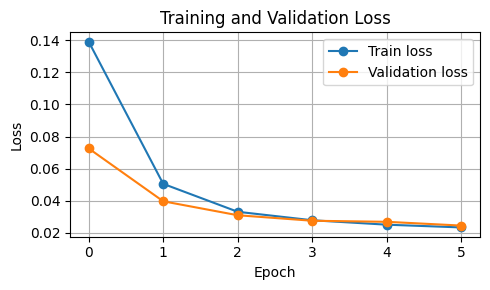

In [41]:
epochs=6
train_loss=[]
val_loss=[]
train_epoch_loss=0
val_epoch_loss=0
for e in range(epochs):
    print(f'----------------------epoch: {e}-----------------')
    for i,(img_batch,depth_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        img_batch=img_batch.to(device,non_blocking=True)
        depth_batch=depth_batch.to(device,non_blocking=True)
        # img_batch=img_batch.to(device)
        # depth_batch=depth_batch.to(device)
        with torch.no_grad():      
            patch_h, patch_w = img_batch.shape[-2] // 14, img_batch.shape[-1] // 14
            features = encoder.get_intermediate_layers(img_batch,[2,5,8, 11])
            del img_batch
    
        y_pred=decoder(features)
        y_pred=torch.tanh(y_pred)+1
        loss_mae=lmse(y_pred,depth_batch.unsqueeze(1))
        loss=loss_mae
        
        
        
        loss.backward()
        optimizer.step()
        if (i%16==0):
            # print(f'Batch {i},Loss:{loss.item()},lsim:{loss_sim.item()},lsilog:{loss_silog.item()}')
             print(f'Batch {i}*************************************************')
             print(f'Loss:{loss.item()}')
             print(f'mae:{loss_mae.item()}')
             
             # for name, param in decoder.named_parameters():
             #    if param.grad is not None:
             #        print(f"{name} grad mean: {param.grad.mean().item()}, max: {param.grad.max().item()}")

        del loss,y_pred,depth_batch,features
        train_epoch_loss+=loss_mae.cpu().detach().item()
        del loss_mae
        
        
        torch.cuda.empty_cache()
    print(i)    
    train_loss.append(train_epoch_loss/(i+1))
   

    
    i=0
    for i,(img_batch,depth_batch) in enumerate(val_dataloader):
       
        img_batch=img_batch.to(device,non_blocking=True)
        depth_batch=depth_batch.to(device,non_blocking=True)
       
        with torch.no_grad():      
            patch_h, patch_w = img_batch.shape[-2] // 14, img_batch.shape[-1] // 14
            features = encoder.get_intermediate_layers(img_batch,[2,5,8, 11])
            del img_batch
    
            y_pred=decoder(features)
            y_pred=torch.tanh(y_pred)+1
            loss_mae=lmse(y_pred,depth_batch.unsqueeze(1))
            loss=loss_mae
        
        
        
       
        del loss,y_pred,depth_batch,features,
        val_epoch_loss+=loss_mae.cpu().detach().item()
        del loss_mae

        
        torch.cuda.empty_cache()
    print(i)
    val_loss.append(val_epoch_loss/(i+1))
    train_epoch_loss=0
    val_epoch_loss=0

    clear_output(wait=True)
    plt.figure(figsize=(5,3))
    plt.plot(train_loss,label='Train loss',marker='o')
    plt.plot(val_loss,label='Validation loss',marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True) 
    plt.tight_layout()
    plt.show()
            
        
        
        
        

In [63]:
test_epoch_loss=0
for i,(img_batch,depth_batch) in enumerate(test_dataloader):
       
        img_batch=img_batch.to(device,non_blocking=True)
        depth_batch=depth_batch.to(device,non_blocking=True)
       
        with torch.no_grad():      
            patch_h, patch_w = img_batch.shape[-2] // 14, img_batch.shape[-1] // 14
            features = encoder.get_intermediate_layers(img_batch,[2,5,8, 11])
            del img_batch
    
            y_pred=decoder(features)
            y_pred=torch.tanh(y_pred)+1
            loss_mae=lmse(y_pred,depth_batch.unsqueeze(1))
            loss=loss_mae
        
        
        
       
        del loss,y_pred,depth_batch,features,
        test_epoch_loss+=loss_mae.cpu().detach().item()
        del loss_mae


In [64]:
test_epoch_loss

1.1492559034377337

In [66]:
val_loss[5]

0.02455358751118183

In [50]:
def get_sample_ind(ind):
    
    sample_i = data_frame.iloc[ind]
        
    # Get file names
    img_path = os.path.join('/kaggle/input/nyu-depth-v2/nyu_data', sample_i[0])
    depth_path = os.path.join('/kaggle/input/nyu-depth-v2/nyu_data', sample_i[1])
    
    # Load the images
    # img = torch.tensor(np.array(Image.open(img_path).convert("RGB").resize((504,378))),dtype=float ) # Convert to RGB
    # depth = torch.tensor(np.array(Image.open(depth_path).resize((504,378))),dtype=float ) # 16-bit depth image
    img = Image.open(img_path).convert("RGB") # Convert to RGB
    img=processor(img,return_tensors="pt")['pixel_values'][0]
    depth = torch.tensor(np.array(Image.open(depth_path).resize((224,224))),dtype=float ) # 16-bit depth image
    depth=(depth-depth.min())/(depth.max()-depth.min())
    return img,depth

    
    

In [51]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [52]:
import mediapy as mp
import torch

def show(img):

    
    tensor_img=img.cpu().numpy()

    # Normalize to [0,255] uint8
    img_norm = (tensor_img - tensor_img.min()) / (tensor_img.max() - tensor_img.min() + 1e-8)
    img_uint8 = (img_norm * 255).astype('uint8')
    
    # Show with mediapy
    mp.show_image(img_uint8, title="Depth Prediction")

def get_pred(x):
   
    with torch.no_grad():
       
        
        patch_h, patch_w = x.shape[-2] // 14, x.shape[-1] // 14
        features = encoder.get_intermediate_layers(x,[2, 5, 8, 11])
        y_pred=decoder(features)
    return y_pred[0]

In [58]:
testimg,testdepth=get_sample_ind(189)
pred=get_pred(testimg.to(device).unsqueeze(0))

In [59]:
torch.tanh(pred.squeeze(0))+1

tensor([[0.6766, 0.5720, 0.5795,  ..., 0.2556, 0.3069, 0.4472],
        [0.6020, 0.4904, 0.5105,  ..., 0.2378, 0.2844, 0.3081],
        [0.5314, 0.3936, 0.4099,  ..., 0.2045, 0.2531, 0.2684],
        ...,
        [0.0871, 0.1552, 0.1171,  ..., 0.2191, 0.2545, 0.1561],
        [0.1378, 0.1883, 0.1135,  ..., 0.2058, 0.2501, 0.1575],
        [0.2057, 0.1916, 0.1259,  ..., 0.1867, 0.2325, 0.2776]],
       device='cuda:0')

In [60]:
testdepth

tensor([[0.4659, 0.4659, 0.4659,  ..., 0.1932, 0.1818, 0.1818],
        [0.4659, 0.4659, 0.4659,  ..., 0.1818, 0.1818, 0.1818],
        [0.4659, 0.4659, 0.4773,  ..., 0.1705, 0.1818, 0.1818],
        ...,
        [0.1591, 0.1591, 0.1023,  ..., 0.0114, 0.0227, 0.0227],
        [0.1591, 0.1591, 0.1591,  ..., 0.0227, 0.0227, 0.0227],
        [0.1591, 0.1591, 0.1591,  ..., 0.0227, 0.0227, 0.0227]],
       dtype=torch.float64)

Depth Prediction

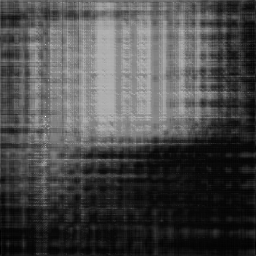

In [61]:
show(torch.tanh(pred.squeeze(0))+1)


Depth Prediction

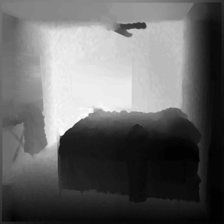

In [62]:
show(testdepth)